In [1]:
# Import packages and define functions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.transform import resize

def index_generator(num):
    if num < 10:
        return '000' + str(num)
    elif num < 100:
        return '00' + str(num)
    else:
        return '0' + str(num)
    
def mse(A, B):
    return np.square(np.subtract(A, B)).mean()
    
X_path = r"data\phantom_1\image_Mark_D10\ExVivo_Brain_30_A2_T2_2017-10-03_"
Y_path = r"data\phantom_1\Processed_Final_D10\ExVivo_Brain_30_A2_T2_2017-10-03_DFT_01.csv"

In [2]:
# Load MLP data format

X_train = []

DATA_LENGTH = 256
NUM_FRAMES = 256

# load each B-frame
for i in range(NUM_FRAMES):
    input_path = X_path + index_generator(i) + ".oct.csv"
    B_frame = pd.read_csv(input_path, header=None).to_numpy()
    B_frame = resize(B_frame, (DATA_LENGTH, 52))
    
    # load each A-line
    for k in range(52):
        A_line = B_frame[:,k]
        X_train.append(A_line)
    
X_train = np.stack(X_train, axis=0)

Y_train = pd.read_csv(Y_path, header=None).to_numpy()
Y_train = np.reshape(Y_train, (256*52,1))

print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))

X_train shape: (13312, 256)
Y_train shape: (13312, 1)


[[3.8536577 ]
 [3.84452067]
 [3.89256694]
 ...
 [5.08212669]
 [4.73590752]
 [4.63268967]]


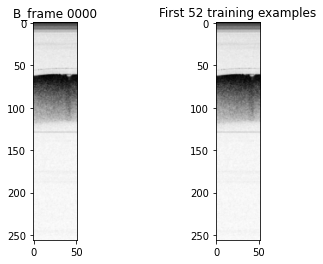

0.0


In [3]:
# Visualize MLP data

# Verify Y_train has been reshaped in left-right, top-down order
# Expected:
# [[3.8536577 ]
#  [3.84452067]
#  [3.89256694]
#  ...
#  [5.08212669]
#  [4.73590752]
#  [4.63268967]]
print(Y_train)

# Verify X_train is stacked correctly (i.e. first row is first A-line of first frame)\
plt.subplots(1,2)

plt.subplot(1,2,1)
B_frame_0000 = pd.read_csv(X_path + '0000.oct.csv', header=None).to_numpy()
B_frame_0000 = resize(B_frame_0000, (DATA_LENGTH, 52))
plt.title("B_frame 0000")
plt.imshow(B_frame_0000, cmap='gray')

plt.subplot(1,2,2)
X_frame = np.transpose(X_train[0:52,:])
plt.title("First 52 training examples")
plt.imshow((X_frame), cmap='gray')

plt.show()

print(np.sum(B_frame_0000-X_frame))

In [19]:
# A-line to scalar attenuation MLP

inputs = tf.keras.Input(shape=(DATA_LENGTH,))
hidden1 = tf.keras.layers.Dense(128, activation='sigmoid')(inputs)
hidden1 = tf.keras.layers.Dropout(0.5)(hidden1)
hidden2 = tf.keras.layers.Dense(64, activation='sigmoid')(hidden1)
hidden2 = tf.keras.layers.Dropout(0.5)(hidden2)
hidden3 = tf.keras.layers.Dense(32, activation='sigmoid')(hidden2)
hidden3 = tf.keras.layers.Dropout(0.5)(hidden3)
outputs = tf.keras.layers.Dense(1, activation='relu')(hidden3)

model_dense = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model_dense.compile(loss='mse', optimizer='adam')
model_dense.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0   

Epoch 1/100
375/375 [==============================] - 2s 3ms/step - loss: 4.1063 - val_loss: 1.8034
Epoch 2/100
375/375 [==============================] - 1s 3ms/step - loss: 2.3737 - val_loss: 1.8615
Epoch 3/100
375/375 [==============================] - 1s 3ms/step - loss: 2.2176 - val_loss: 1.9686
Epoch 4/100
375/375 [==============================] - 1s 3ms/step - loss: 2.0918 - val_loss: 1.9174
Epoch 5/100
375/375 [==============================] - 1s 3ms/step - loss: 1.9694 - val_loss: 1.9168
Epoch 6/100
375/375 [==============================] - 1s 3ms/step - loss: 1.8451 - val_loss: 1.8675
Epoch 7/100
375/375 [==============================] - 1s 3ms/step - loss: 1.7098 - val_loss: 1.7996
Epoch 8/100
375/375 [==============================] - 1s 3ms/step - loss: 1.6363 - val_loss: 1.9056
Epoch 9/100
375/375 [==============================] - 1s 3ms/step - loss: 1.5243 - val_loss: 1.7938
Epoch 10/100
375/375 [==============================] - 1s 3ms/step - loss: 1.2183 - val_lo

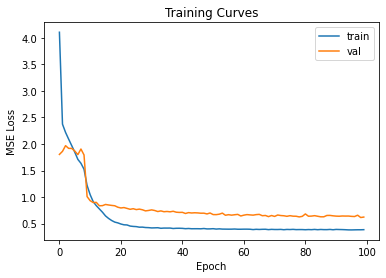

In [20]:
# Train MLP model

history_dense = model_dense.fit(x=X_train, y=Y_train, validation_split=0.1, epochs=100, batch_size=32)

plt.plot(history_dense.history['loss'])
plt.plot(history_dense.history['val_loss'])
plt.title('Training Curves')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [21]:
# Load unseen test data

Y_path_test = r"data\phantom_3\Processed_Final_D10\ExVivo_Brain_30_T1_2017-10-03_DFT_01.csv"
X_path_test = r"data\phantom_3\image_Mark_D10\ExVivo_Brain_30_T1_2017-10-03_"
X_test = []

for i in range(NUM_FRAMES):
    input_path = X_path_test + index_generator(i) + ".oct.csv"
    B_frame = pd.read_csv(input_path, header=None).to_numpy()
    B_frame = resize(B_frame, (DATA_LENGTH, 52))
    
    for k in range(52):
        A_line = B_frame[:,k]
        X_test.append(A_line)
    
X_test = np.stack(X_test, axis=0)

Y_test = pd.read_csv(Y_path_test, header=None).to_numpy()
Y_test = np.reshape(Y_test, (256*52,1))

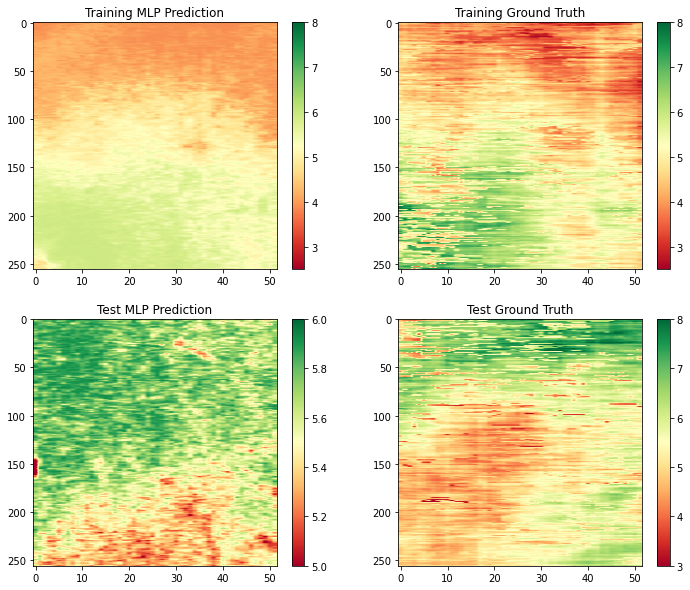

MSE on training data: 0.3584272935734794
MSE on testing data: 0.8136322880068434


In [34]:
# Test MLP model

# Try on training data
attenuation_map = np.reshape(Y_train, (256,52))
pred_attenuation_map = model_dense.predict(X_train, batch_size=128)
pred_attenuation_map = np.reshape(pred_attenuation_map, (256,52))

# Try on testing data
attenuation_map_test = np.reshape(Y_test, (256,52))
pred_attenuation_map_test = model_dense.predict(X_test, batch_size=128)
pred_attenuation_map_test = np.reshape(pred_attenuation_map_test, (256,52))

plt.subplots(2,2,figsize=(12,10))
plt.subplot(2,2,1)
plt.title("Training MLP Prediction")
plt.imshow(pred_attenuation_map, aspect='auto', cmap='RdYlGn', vmin=2.5, vmax=8)
plt.colorbar()

plt.subplot(2,2,2)
plt.title("Training Ground Truth")
plt.imshow(attenuation_map, aspect='auto', cmap='RdYlGn', vmin=2.5, vmax=8)
plt.colorbar()

plt.subplot(2,2,3)
plt.title("Test MLP Prediction")
plt.imshow(pred_attenuation_map_test, aspect='auto', cmap='RdYlGn', vmin=5, vmax=6)
plt.colorbar()

plt.subplot(2,2,4)
plt.title("Test Ground Truth")
plt.imshow(attenuation_map_test, aspect='auto', cmap='RdYlGn', vmin=3, vmax=8)
plt.colorbar()
plt.show()

print("MSE on training data: " + str(mse(attenuation_map, pred_attenuation_map)))
print("MSE on testing data: " + str(mse(attenuation_map_test, pred_attenuation_map_test)))

In [2]:
# Load CNN data format

X_path = [r"data\phantom_1\image_Mark_D10\ExVivo_Brain_30_A2_T2_2017-10-03_", 
          r"data\phantom_3\image_Mark_D10\ExVivo_Brain_30_T1_2017-10-03_"]
Y_path = [r"data\phantom_1\Processed_Final_D10\ExVivo_Brain_30_A2_T2_2017-10-03_DFT_01.csv",
          r"data\phantom_3\Processed_Final_D10\ExVivo_Brain_30_T1_2017-10-03_DFT_01.csv"]

DATA_LENGTH = 256
DATA_WIDTH = 256
NUM_FRAMES = 256

X_train = []
Y_train = []

for k in range(2):
    for i in range(NUM_FRAMES):
        input_path = X_path[k] + index_generator(i) + ".oct.csv"
        B_frame = pd.read_csv(input_path, header=None).to_numpy()
        B_frame = resize(B_frame, (DATA_LENGTH, DATA_WIDTH))
        X_train.append(B_frame)
    
    attenu_map = pd.read_csv(Y_path[k], header=None).to_numpy()
    Y_train.append(attenu_map)
    
X_train = np.stack(X_train, axis=0)
Y_train = np.stack(Y_train, axis=0)
Y_train = np.reshape(Y_train, (512,52))

print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))

X_train shape: (512, 256, 256)
Y_train shape: (512, 52)


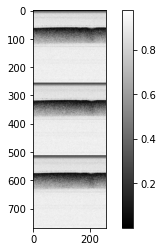

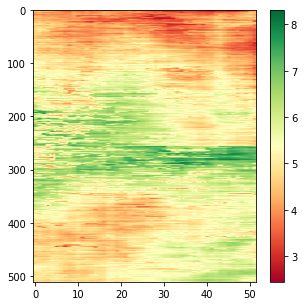

(256, 256, 1)


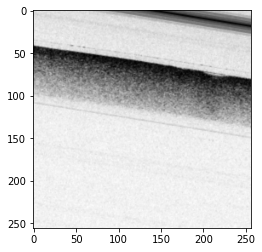

In [56]:
# Visualize CNN data

# Display first 3 inputs
plt.imshow(np.reshape(X_train[0:3,:,:], (DATA_LENGTH*3,DATA_WIDTH)), cmap='gray')
plt.colorbar()
plt.show()

# Attenuation map
plt.figure(figsize=(5,5))
plt.imshow(Y_train, aspect='auto', cmap='RdYlGn')
plt.colorbar()
plt.show()

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

sample = X_train[0,:,:]
sample = np.reshape(sample, (256,256,1))
print(sample.shape)
result = data_augmentation(sample)
plt.imshow(result, cmap='gray')

In [109]:
# B-frame to attenuation vector AlexNet

# Convolutional layers
inputs = tf.keras.Input(shape=(256,256,1))
c1 = tf.keras.layers.Conv2D(16, (7,7), strides=1, activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c2 = tf.keras.layers.Conv2D(52, (7,7), strides=1, activation='relu', kernel_initializer='he_normal', padding='same')(c1)
c3 = tf.keras.layers.Conv2D(52, (7,7), strides=1, activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p1 = tf.keras.layers.MaxPooling2D((16,16), strides=16)(c3)

# Dense layers
f = tf.keras.layers.Flatten()(p1)
f = tf.keras.layers.Dropout(0.5)(f)
outputs = tf.keras.layers.Dense(52, activation='relu')(f)

model_conv = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model_conv.summary()

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 256, 256, 16)      800       
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 256, 256, 52)      40820     
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 256, 256, 52)      132548    
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 52)        0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 13312)             0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 13312)             0  

Epoch 1/50
460/460 [==============================] - 8s 18ms/step - loss: 1.2441 - val_loss: 1.2850
Epoch 2/50
460/460 [==============================] - 8s 18ms/step - loss: 0.5532 - val_loss: 0.7061
Epoch 3/50
460/460 [==============================] - 8s 17ms/step - loss: 0.4456 - val_loss: 0.6182
Epoch 4/50
460/460 [==============================] - 8s 18ms/step - loss: 0.4075 - val_loss: 0.1848
Epoch 5/50
460/460 [==============================] - 8s 17ms/step - loss: 0.3944 - val_loss: 0.2043
Epoch 6/50
460/460 [==============================] - 8s 17ms/step - loss: 0.4065 - val_loss: 0.2327
Epoch 7/50
460/460 [==============================] - 8s 17ms/step - loss: 0.3767 - val_loss: 0.4948
Epoch 8/50
460/460 [==============================] - 8s 17ms/step - loss: 0.3694 - val_loss: 0.2497
Epoch 9/50
460/460 [==============================] - 8s 18ms/step - loss: 0.3846 - val_loss: 0.5287
Epoch 10/50
460/460 [==============================] - 8s 18ms/step - loss: 0.3866 - val_lo

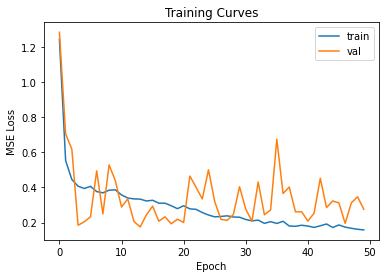

In [110]:
# Train CNN model

model_conv.compile(loss='mse', optimizer='adam')
history_conv = model_conv.fit(x=X_train, y=Y_train, validation_split=0.1, epochs=50, batch_size=1)

plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('Training Curves')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [7]:
# Load unseen test data

Y_path_test = r"data\phantom_5\Processed_Final_D10\ExVivo_Brain_30_T3_2017-10-03_DFT_01.csv"
X_path_test = r"data\phantom_5\image_Mark_D10\ExVivo_Brain_30_T3_2017-10-03_"
X_test = []

for i in range(NUM_FRAMES):
    input_path = X_path_test + index_generator(i) + ".oct.csv"
    B_frame = pd.read_csv(input_path, header=None).to_numpy()
    B_frame = resize(B_frame, (DATA_LENGTH, DATA_WIDTH))
    X_test.append(B_frame)
    
X_test = np.stack(X_test, axis=0)
Y_test = pd.read_csv(Y_path_test, header=None).to_numpy()

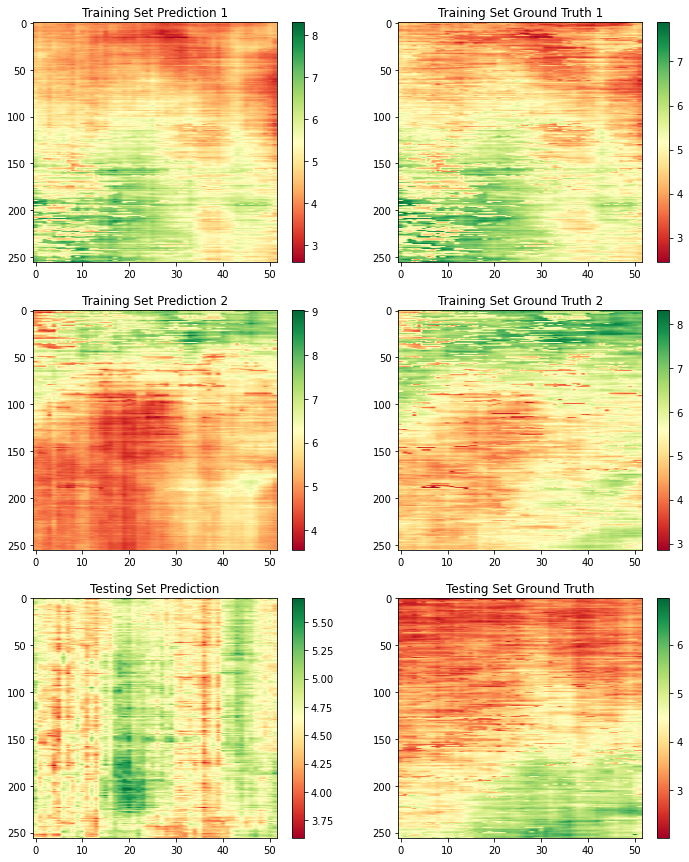

MSE on training data set 1: 0.09075653358894559
MSE on testing data: 1.42430124563342


In [111]:
# Test CNN model

pred_attenuation_map = model_conv.predict(X_train, batch_size=4)
pred_attenuation_map = np.reshape(pred_attenuation_map, (2,256,52))
pred_attenuation_map_test = model_conv.predict(X_test, batch_size=4)

titles=["Training Set Prediction 1", "Training Set Ground Truth 1", 
        "Training Set Prediction 2", "Training Set Ground Truth 2"]

images=[pred_attenuation_map[0,:,:], 
        Y_train[0:256,:],
        pred_attenuation_map[1,:,:],
        Y_train[256:512,:]]

plt.subplots(3,2,figsize=(12,15))

# Plot training example outputs
for i in range(4):
    plt.subplot(3,2,i+1)
    plt.title(titles[i])
    plt.imshow(images[i], aspect='auto', cmap='RdYlGn')
    plt.colorbar()

# Plot testing example outputs
plt.subplot(3,2,5)
plt.title("Testing Set Prediction")
plt.imshow(pred_attenuation_map_test, aspect='auto', cmap='RdYlGn')
plt.colorbar()

plt.subplot(3,2,6)
plt.title("Testing Set Ground Truth")
plt.imshow(Y_test, aspect='auto', cmap='RdYlGn')
plt.colorbar()

plt.show()

print("MSE on training data set 1: " + str(mse(images[0],images[1])))
print("MSE on testing data: " + str(mse(Y_test, pred_attenuation_map_test)))

In [146]:
# B-frame to attenuation vector U-net

inputs = tf.keras.Input(shape=(256,256,1), name='Input')

def network(inputs, padding='valid', kernel_size=7, filters=32):
    # Data augmentation
    inputs = tf.keras.layers.RandomRotation(0.2)(inputs)
    inputs = tf.keras.layers.RandomFlip()(inputs)
    
    # Contraction path
    c1 = tf.keras.layers.Conv2D(filters, kernel_size, strides=1, activation='relu', kernel_initializer='he_normal', padding=padding, name='Conv1')(inputs)
    c2 = tf.keras.layers.Conv2D(filters, kernel_size, strides=1, activation='relu', kernel_initializer='he_normal', padding=padding, name='Conv2')(c1)
    c3 = tf.keras.layers.Conv2D(filters, kernel_size, strides=1, activation='relu', kernel_initializer='he_normal', padding=padding, name='Conv3')(c2)
    c4 = tf.keras.layers.Conv2D(filters, kernel_size, strides=1, activation='relu', kernel_initializer='he_normal', padding=padding, name='Bottleneck4')(c3)

    # Expansion path
    c5 = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=1, activation='relu', kernel_initializer='he_normal', padding=padding, name='Deconv5')(c4)
    c5 = tf.keras.layers.concatenate([c5, c3], name='Layer5')
    c6 = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=1, activation='relu', kernel_initializer='he_normal', padding=padding, name='Deconv6')(c5)
    c6 = tf.keras.layers.concatenate([c6, c2], name='Layer6')
    c7 = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=1, activation='relu', kernel_initializer='he_normal', padding=padding, name='Deconv7')(c6)
    c7 = tf.keras.layers.concatenate([c7, c1], name='Layer7')
    
    c8 = tf.keras.layers.Conv2DTranspose(1, kernel_size, strides=1, activation='relu', kernel_initializer='he_normal', padding=padding, name='Deconv8')(c7)

    # AlexNet Path
    #c9 = tf.keras.layers.Conv2D(16, kernel_size, strides=1, activation='relu', kernel_initializer='he_normal', padding='same', name='Conv9')(c8)
    #c10 = tf.keras.layers.Conv2D(52, kernel_size, strides=1, activation='relu', kernel_initializer='he_normal', padding='same', name='Conv10')(c9)
    #c11 = tf.keras.layers.Conv2D(52, kernel_size, strides=1, activation='relu', kernel_initializer='he_normal', padding='same', name='Conv11')(c10)
    #p1 = tf.keras.layers.MaxPooling2D((16,16), strides=16)(c11)
    p1 = tf.keras.layers.Conv2D(52, (16,16), strides=16, activation='relu', kernel_initializer='he_normal', padding='valid')(c8)
    f = tf.keras.layers.Flatten()(p1)
    f = tf.keras.layers.Dropout(0.5)(f)
    outputs = tf.keras.layers.Dense(52, activation='relu')(f)

#     c9 = tf.keras.layers.Conv2D(52, 16, strides=16, activation='relu', kernel_initializer='he_normal', padding='valid')(c8)
#     c10 = tf.keras.layers.Conv2D(52, 16, strides=16, activation='relu', kernel_initializer='he_normal', padding='valid')(c9)
#     outputs = tf.keras.layers.Flatten()(c10)

    return outputs


model_unet = tf.keras.Model(inputs=[inputs], outputs=[network(inputs)])
model_unet.summary()

Model: "model_54"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
random_rotation_83 (RandomRotat (None, 256, 256, 1)  0           Input[0][0]                      
__________________________________________________________________________________________________
random_flip_80 (RandomFlip)     (None, 256, 256, 1)  0           random_rotation_83[0][0]         
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 250, 250, 32) 1600        random_flip_80[0][0]             
___________________________________________________________________________________________

Epoch 1/50
460/460 [==============================] - 16s 34ms/step - loss: 1.9052 - val_loss: 0.3842
Epoch 2/50
460/460 [==============================] - 17s 37ms/step - loss: 1.3005 - val_loss: 0.9788
Epoch 3/50
460/460 [==============================] - 19s 42ms/step - loss: 1.0850 - val_loss: 0.5482
Epoch 4/50
460/460 [==============================] - 17s 37ms/step - loss: 1.1218 - val_loss: 0.8748
Epoch 5/50
460/460 [==============================] - 16s 35ms/step - loss: 1.1433 - val_loss: 0.3203
Epoch 6/50
460/460 [==============================] - 18s 39ms/step - loss: 1.1231 - val_loss: 0.3725
Epoch 7/50
460/460 [==============================] - 18s 39ms/step - loss: 1.0900 - val_loss: 0.3809
Epoch 8/50
460/460 [==============================] - 17s 37ms/step - loss: 1.0638 - val_loss: 0.4295
Epoch 9/50
460/460 [==============================] - 16s 36ms/step - loss: 1.1181 - val_loss: 0.7295
Epoch 10/50
460/460 [==============================] - 16s 35ms/step - loss: 1.059

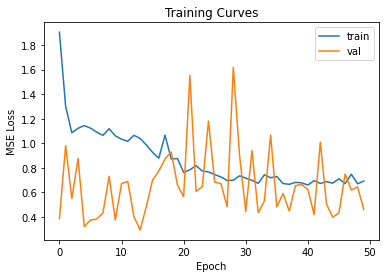

In [147]:
# Train UNet model

model_unet.compile(loss='mse', optimizer='adam')
history_unet = model_unet.fit(x=X_train, y=Y_train, validation_split=0.1, epochs=50, batch_size=1)

plt.plot(history_unet.history['loss'])
plt.plot(history_unet.history['val_loss'])
plt.title('Training Curves')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

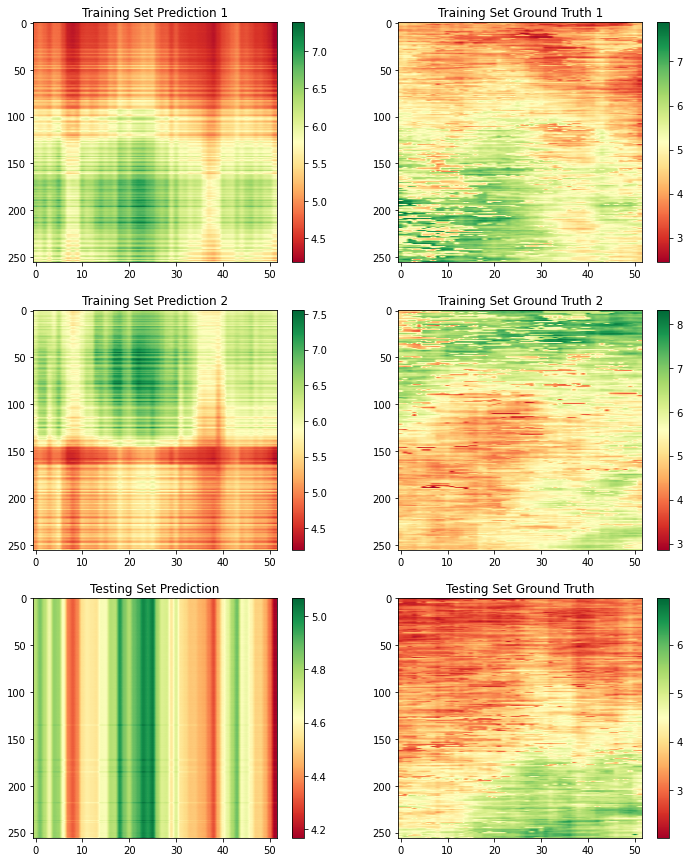

MSE on training data set 1: 0.772376905968896
MSE on testing data: 1.351056272205993


In [148]:
# Test UNet model

pred_attenuation_map = model_unet.predict(X_train, batch_size=4)
pred_attenuation_map = np.reshape(pred_attenuation_map, (2,256,52))
pred_attenuation_map_test = model_unet.predict(X_test, batch_size=4)

titles=["Training Set Prediction 1", "Training Set Ground Truth 1", 
        "Training Set Prediction 2", "Training Set Ground Truth 2"]

images=[pred_attenuation_map[0,:,:], 
        Y_train[0:256,:],
        pred_attenuation_map[1,:,:],
        Y_train[256:512,:]]

plt.subplots(3,2,figsize=(12,15))

# Plot training example outputs
for i in range(4):
    plt.subplot(3,2,i+1)
    plt.title(titles[i])
    plt.imshow(images[i], aspect='auto', cmap='RdYlGn')
    plt.colorbar()

# Plot testing example outputs
plt.subplot(3,2,5)
plt.title("Testing Set Prediction")
plt.imshow(pred_attenuation_map_test, aspect='auto', cmap='RdYlGn')
plt.colorbar()

plt.subplot(3,2,6)
plt.title("Testing Set Ground Truth")
plt.imshow(Y_test, aspect='auto', cmap='RdYlGn')
plt.colorbar()

plt.show()

print("MSE on training data set 1: " + str(mse(images[0],images[1])))
print("MSE on testing data: " + str(mse(Y_test, pred_attenuation_map_test)))